In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from catboost import CatBoostClassifier, Pool, cv,CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score
import seaborn as sns
import statsmodels.api as sm # Import StatsModels modules


%matplotlib inline

pd.set_option("max_columns",1000)

# Business Understanding

**Question 1:**

How does price and availability of airbnb listings in Seattle and Boston change over time? Are there any seasonal patterns? 

**Question 2:**

Do the amenities provided by the host have impact on price and review ratings? This may help hosts improve their listings to increace price and revenue.

**Question 3:**

What key feautures impact the listings price the most? Can we predict the listing price well with LinearRegression Model? Can we have a better prediction by using other Model? 


# Load Datasets and Data Preparation

In [56]:
# dataset for Seattle
sea_cal = pd.read_csv('seattle/calendar.csv')
sea_list = pd.read_csv('seattle/listings.csv')
sea_rev = pd.read_csv('seattle/reviews.csv')


# dataset for Boston

bos_cal = pd.read_csv('boston/calendar.csv')
bos_list = pd.read_csv('boston/listings.csv')
bos_rev = pd.read_csv('boston/reviews.csv')

In [57]:
# In order to merge both cities to one dataset, I create a "city" column to identify the cities

sea_cal["city"] = "Seattle"
sea_list["city"] = "Seattle"
sea_rev["city"] = "Seattle"

bos_cal["city"] = "Boston"
bos_list["city"] = "Boston"
bos_rev["city"] = "Boston"

## merge both datasets 
calendar = pd.concat([sea_cal, bos_cal]).reset_index(drop=True)
reviews = pd.concat([sea_rev, bos_rev]).reset_index(drop=True)
listings = pd.concat([sea_list, bos_list]).reset_index(drop=True)

/Users/leec/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [58]:
# Look closer into data and the types of each variable
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 95 columns):
access                              2096 non-null object
accommodates                        7403 non-null int64
amenities                           7403 non-null object
availability_30                     7403 non-null int64
availability_365                    7403 non-null int64
availability_60                     7403 non-null int64
availability_90                     7403 non-null int64
bathrooms                           7373 non-null float64
bed_type                            7403 non-null object
bedrooms                            7387 non-null float64
beds                                7393 non-null float64
calculated_host_listings_count      7403 non-null int64
calendar_last_scraped               7403 non-null object
calendar_updated                    7403 non-null object
cancellation_policy                 7403 non-null object
city                                7403 

## Select relevant variables
**To have a dataset with only relevant information for my model, I choose to drop the following features:**
1. all columns contain url
2. all columns regarding detailed geolocations such as countrycode and zipcode
3. all columns in long text forms like houserules, interaction
4. columns only available for one city like has_availability and neighbourhood_group_cleansed or other less influential variables regarding price and booking behavior

In [59]:
cols = listings.columns
cols[cols.str.contains("url") ==True]
url = ['host_picture_url', 'host_thumbnail_url', 'host_url', 'listing_url',
       'medium_url', 'picture_url', 'thumbnail_url', 'xl_picture_url']

cols[cols.str.contains("location") ==True]
location = ["state","street","zipcode","country_code","country","latitude","longitude",'host_location', 
            'is_location_exact', 'review_scores_location','smart_location']

cols[cols.str.contains("name") ==True]
infos = ["access","summary","interaction","house_rules",'host_name', 'jurisdiction_names', 
 'name',"notes","description","space","transit","experiences_offered","host_about","neighborhood_overview"]

nonre = ["has_availability","license","requires_license","square_feet","last_scraped","scrape_id",
        "host_verifications", "host_since","neighbourhood_group_cleansed","market"]
        
droplist = url + location +infos +nonre
listings.drop(droplist,axis=1,inplace=True)

In [60]:
# check numerical data 
listings.describe()

,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bedrooms,beds,calculated_host_listings_count,guests_included,host_id,host_listings_count,host_total_listings_count,id,maximum_nights,minimum_nights,number_of_reviews,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_rating,review_scores_value,reviews_per_month
count,7403.000000,7403.000000,7403.000000,7403.000000,7403.000000,7373.000000,7387.000000,7393.000000,7403.000000,7403.000000,7.403000e+03,7401.000000,7401.000000,7.403000e+03,7.403000e+03,7403.000000,7403.000000,5922.000000,5925.000000,5932.000000,5934.000000,5943.000000,5926.000000,6020.000000
mean,3.200189,12.846143,213.089153,29.559773,48.627583,1.241150,1.282659,1.674286,7.686073,1.555045,2.021053e+07,32.222537,32.222537,6.950001e+06,1.431337e+04,2.757666,20.684047,9.540865,9.721181,9.417229,9.733569,93.316002,9.319777,2.028161
std,1.890166,12.069956,138.342837,23.839400,35.013315,0.549408,0.823251,1.081355,21.465871,1.200756,1.962309e+07,123.585161,123.585161,4.052397e+06,1.162232e+06,13.243828,36.733024,0.821783,0.682247,0.999271,0.656589,8.207451,0.892824,1.968696
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.193000e+03,0.000000,0.000000,3.335000e+03,1.000000e+00,1.000000,0.000000,2.000000,2.000000,2.000000,2.000000,20.000000,2.000000,0.010000
25%,2.000000,0.000000,77.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.343164e+06,1.000000,1.000000,3.864100e+06,9.550000e+01,1.000000,1.000000,9.000000,10.000000,9.000000,10.000000,91.000000,9.000000,0.590000
50%,2.000000,10.000000,259.000000,31.000000,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.448650e+07,1.000000,1.000000,7.035240e+06,1.125000e+03,2.000000,7.000000,10.000000,10.000000,10.000000,10.000000,96.000000,9.000000,1.370000
75%,4.000000,26.000000,347.000000,55.000000,84.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.028359e+07,4.000000,4.000000,9.500804e+06,1.125000e+03,3.000000,23.000000,10.000000,10.000000,10.000000,10.000000,99.000000,10.000000,2.890000
max,16.000000,30.000000,365.000000,60.000000,90.000000,8.000000,7.000000,16.000000,136.000000,15.000000,9.385411e+07,749.000000,749.000000,1.493346e+07,1.000000e+08,1000.000000,474.000000,10.000000,10.000000,10.000000,10.000000,100.000000,10.000000,19.150000


## Clean Dataset

### Clean and Pivot amenties column

Each row of the amenities column is a list of amenities.
For every single item in the list I create an additional column and set the value as follows:<br>
        to 1 if the item is available in the listing-id <br>
        to 0 if it is not available in the listing-id

In [61]:
# clean amenities column
listings.amenities.replace({"\\{":"","\\}":"",'\\"':""," ":"_"},inplace=True,regex=True)
listings.amenities= listings.amenities.str.lower()

## select amenities with listing-id as a new dataframe
amenities = listings[["id","amenities"]]
## Split the list in each row by "," and expand a new column for each item 
amenities_cl = amenities.set_index('id').amenities.str.split(',', expand=True).stack()
## sum all the items by id and using the get_dummies function to get our new amenities table 
amenities_cl= pd.get_dummies(amenities_cl,prefix="amenities").groupby(level=0).sum().reset_index()
# drop the origin amenities column
amenities_cl.drop("amenities_",axis=1,inplace=True) 

### Clean and Impute numerical variables

The data frame listings contains columns with Dollar sign and percentage sign. For example security_deposit, cleaning_fee, price, extra_people, host_response_rate etc. These values need to be converted to numeric.
For the imputation I use the mean to fill the missing values.

In [62]:
# clean the dataframes, replacing $ and % in the price and rate columns
df = listings.copy()
df.replace({"\\$":"","\\%":"","\\,":""},inplace=True,regex=True)

calendar.rename(columns={"price":"cleaned_price"},inplace=True)
calendar.replace({"\\$":"","\\%":"","\\,":""},inplace=True,regex=True)
calendar.cleaned_price = calendar.cleaned_price.astype(float)

#select cols in str but need to be changed in num
to_num = ["extra_people","host_acceptance_rate","cleaning_fee",
          "host_response_rate","monthly_price","price","weekly_price","security_deposit"]

col_num = lambda col: col.astype(float)
df[to_num]= df[to_num].apply(col_num,axis=0)

In [63]:
# Missing values of numerical variables
num_var = df.select_dtypes(["float","int"])
# I choose to impute the mean for the columns of the dataframe by using the apply method
fill_mean = lambda col: col.fillna(col.mean())
df_num=num_var.apply(fill_mean, axis=0)

# clean price column in dataframe calendar 
calendar.cleaned_price = calendar.cleaned_price.fillna(calendar.cleaned_price.mean())

In [64]:
# select all categorical variabels and concatenate with df_num
df_cat = df.select_dtypes(["object"])
df = pd.concat([df_cat, df_num],axis=1).reset_index(drop=True)

# Merge the amenities_cleaned columns on listing-id to our dataset listings
df = pd.merge(df,amenities_cl, on="id")

# Merge the date column on listing-id to our dataset
df = pd.merge(df,calendar[["listing_id","date","cleaned_price","available"]], left_on="id",right_on="listing_id")

### Clean and Impute categorical variables

The column neighbourhood_cleansed is the cleaned var of host_neighbourhood and neighbourhood, so I will drop these two columns. The column amenities is already cleaned above and can be dropped too. After data cleaning I create two data frames for my exploration in section 3 and modeling in section 4. 
 

In [65]:
# Drop columns
df_cat.drop(["host_neighbourhood","neighbourhood", "amenities"],axis=1,inplace=True)

# host_response_time,property_type,host_has_profile_pic,host_identity_verified,host_is_superhost
# are the columns with missing values

## convert columns like first_review and last_review to datetime format
df_cat["first_review"] = pd.to_datetime(df.first_review)
df_cat["last_review"] = pd.to_datetime(df.last_review)

#Pull a list of the column names of the categorical variables
cat_var = df_cat.copy()
cat_var = cat_var.select_dtypes(["object"])
cat_var.drop(["city"],axis=1,inplace=True)
cat_cols = cat_var.columns

## Here I create two tables
### df1 is the cleaned table with cleaned amenities and numerical variables without categorical variables
df1 = df.copy()
df1=df1.drop(["city","host_neighbourhood","neighbourhood","available"],axis=1)
df_cat1 = df1.select_dtypes(["object"])
cat_cols1 = df_cat1.columns
df1 = df1.drop(df_cat1, axis=1)
## rename columns
df1.rename(str.lower, axis='columns')
df1.columns =df1.columns.str.replace(" ","_")

### df_new is the table with all numerical and categorical variables cleaned
df.drop("amenities",axis=1,inplace=True)

# use the function from the course
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


## cleaned table
df_new = create_dummy_df(df, cat_cols, dummy_na=False)

# Exploratory Data Analysis

In [66]:
# Create year, month, day and weekday columns 
df.date = pd.to_datetime(df.date)
df["day"] = pd.to_datetime(df.date).dt.day
df["month"] = pd.to_datetime(df.date).dt.month
df["year"] = pd.to_datetime(df.date).dt.year
df["weekday"] = pd.to_datetime(df.date).dt.weekday

df.cleaned_price = df.cleaned_price.round(1)

 ## Question 1: <br> How does price and availability of airbnb listings in Seattle and Boston change over time? <br>Are there any seasonal patterns?

In the calendar dataset we have a available and a price variable. For each given date in the period, if the listing object is available, the price belong to the listing id is given, otherwise there is no price given. The time-series graph here is based on these columns and illustrate the average daily rates in Boston and Seattle for each date.

### Rates of Listings

In [67]:
## look into price in Boston and Seattle
meanprice = df[["date","city","cleaned_price"]].groupby(["date","city"]).cleaned_price.mean().reset_index()
meanprice.cleaned_price = meanprice.cleaned_price.round(1)

sea_mp = meanprice[meanprice["city"] =="Seattle"]
bos_mp = meanprice[meanprice["city"] =="Boston"]

#average price in the whole period
sea_mp.cleaned_price.mean() # Seattle $146
bos_mp.cleaned_price.mean() # Boston $180

price_date = go.Figure()
price_date.add_trace(go.Scatter(x=sea_mp.date, y=sea_mp.cleaned_price,mode ="lines", name = "Seattle",text="Average Price in $"))
price_date.add_trace(go.Scatter(x=bos_mp.date, y=bos_mp.cleaned_price,mode ="lines", name = "Boston",text="Average Price in $"))          
price_date.update_layout(xaxis_title = "Date",yaxis_title="Average Rate in Dollar")

price_date.show()

The data for Boston covers from 2016-09-06 to 2017-09-05 and the data for Seattle covers from 2016-01-04 to 2017-01-02. In both cities we can observe jigsaw patterns in the given period and also several peaks of daily rates. In general, the rates in Seattle are significantly lower than in Boston. As the given period does not include a whole calendar year, also the given time frame for both cities is inconsistent, we are not able to identify seasonal patterns. Therefore I am going to explore the average listings price per month of each city in the next chart.

In [68]:
## look into average rates by month in Boston and Seattle
meanprice_m = df[["month","city","cleaned_price"]].groupby(["month","city"]).cleaned_price.mean().reset_index()
meanprice_m.month.replace({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
                          9:"September",10:"October",11:"November",12:"December"},inplace=True)
sea_mp_m = meanprice_m[meanprice_m["city"] =="Seattle"]
bos_mp_m = meanprice_m[meanprice_m["city"] =="Boston"]

price_month = go.Figure()
price_month.add_trace(go.Bar(x=sea_mp_m.month, y=sea_mp_m.cleaned_price,text = "Seattle",name="Average Rate in Seattle"))
price_month.add_trace(go.Bar(x=bos_mp_m.month, y=bos_mp_m.cleaned_price,text = "Boston",name="Average Rate in Boston"))         
price_month.update_layout(yaxis_title="Average Rate in Dollar")
price_month.show()

In the second plot we can see the average monthly rates in both cities. In Boston, October is the month with the highest average rates, March is the month with the lowest average rates, the rates difference between the two seasons is at about 20 Dollars. In Seattle, the rates are higher in summer months and lower during winter. The average rates difference is at about 19 Dollars. Since the time frame of the datasets for both cities are inconsistent, we are not able to compare the rates trend.

In [69]:
## look into price in Boston and Seattle
meanprice_wd = df[["weekday","city","cleaned_price"]].groupby(["weekday","city"]).cleaned_price.mean().reset_index()
meanprice_wd.cleaned_price = meanprice_wd.cleaned_price.round(1)

#rename weekdays
meanprice_wd.weekday.replace({6:"Sunday",0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday"},inplace=True)
sea_mp_wd = meanprice_wd[meanprice_wd["city"] =="Seattle"]
bos_mp_wd = meanprice_wd[meanprice_wd["city"] =="Boston"]


price_weekday = go.Figure()
price_weekday.add_trace(go.Bar(x=sea_mp_wd.weekday, y=sea_mp_wd.cleaned_price,name = "Seattle",text="Average Price in $"))
price_weekday.add_trace(go.Bar(x=bos_mp_wd.weekday, y=bos_mp_wd.cleaned_price,name = "Boston",text="Average Price in $"))      
price_weekday.update_layout(yaxis_title="Average Rate in Dollar")

price_weekday.show()

The third plot shows the rates aggregated on weekdays. As we can see, the rates on Friday and Saturday are higher than other weekdays. Tuesday is the weekday with the lowest rate in both cities. The average rate for a listing in Boston on Friday and Saturday is at 182 Dollars, in Seattle at about 150 Dollars. On the rest of the weekdays the rate is up to 3.9 Dollars lower in Boston and Seattle up to 5.3 Dollars lower.

### Availability of listings <br> How does the average availability vary over time?

Like the section about the rates, I use a time-series plot to visualize the proportion of available listings for each date.

In [70]:
# Availability
df['available'] = np.where(df.available =="t", 1, 0)

avail = df[["date","city","available"]].groupby(["date","city"]).available.mean().reset_index()
avail.available = avail.available.round(4)*100
sea_avail = avail[avail["city"] =="Seattle"]
bos_avail = avail[avail["city"] =="Boston"]

avail_date = go.Figure()
avail_date.add_trace(go.Scatter(x=sea_avail.date, y=sea_avail.available,mode ="lines",name="Seattle", text="avg availability in %"))
avail_date.add_trace(go.Scatter(x=bos_avail.date, y=bos_avail.available,mode ="lines",name="Boston", text="avg availability in %"))           
avail_date.update_layout(xaxis_title = "Date",yaxis_title="Availability in Percent")

avail_date.show()

Both cities show similar trends of average availability in the first six months of the given period. After that, the average availability in Seattle slightly increase about 10 percent. The availability  in Boston remains mostly stable with few exceptions.

The increasing trend in the first 6 months is probably not a reflection of a real-world behavior, it is much like a result of the sample selection method. It seems that the dataset mostly select the incoming hosts in the first six month and not the existing hosts, the yet-to-become listings would be recorded as unavailable before they become a host, which may falsely skew the trend and generate a increasing trend at the beginning of the period. 


In [71]:
# Number of listings
len(sea_list.id.unique()) # Seattle 3818
len(bos_list.id.unique()) # Boston 3585

3585

In [72]:
avail_m = df[["month","city","available"]].groupby(["month","city"]).available.mean().reset_index()
avail_m.month.replace({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
                          9:"September",10:"October",11:"November",12:"December"},inplace=True)
avail_m.available = avail_m.available.round(4)*100
sea_avail_m = avail_m[avail_m["city"] =="Seattle"]
bos_avail_m = avail_m[avail_m["city"] =="Boston"]
# percentage of availability per year
sea_avail_m.mean()#67%
bos_avail_m.mean()#49%
avail_month = go.Figure()
avail_month.add_trace(go.Bar(x=sea_avail_m.month, y=sea_avail_m.available,name="Seattle", text="avg availability in %"))
avail_month.add_trace(go.Bar(x=bos_avail_m.month, y=bos_avail_m.available,name="Boston", text="avg availability in %"))          
avail_month.update_layout(yaxis_title="Availability in Percent")

avail_month.show()

The second availability plot shows the average availability of the listings by month. In general, the average listing vacancies in Seattle is significantly higher than in Boston. Seattle has lowest listings vacancies in January and highest listings vacancies in December. The average availability in Boston is mostly at about 55 to 65 percent throughout the whole period. We can also identify low vacancies in September and October 2016, the availability is at 30-40 percent in these two months. 

In [73]:
avail_wd = df[["weekday","city","available"]].groupby(["weekday","city"]).available.mean().reset_index()
avail_wd.weekday.replace({6:"Sunday",0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday"},inplace=True)
sea_avail_wd = avail_wd[avail_wd["city"] =="Seattle"]
bos_avail_wd = avail_wd[avail_wd["city"] =="Boston"]

avail_weekday = go.Figure()
avail_weekday.add_trace(go.Bar(x=sea_avail_wd.weekday, y=sea_avail_wd.available,name="Seattle", text="avg availability in %"))
avail_weekday.add_trace(go.Bar(x=bos_avail_wd.weekday, y=bos_avail_wd.available,name="Boston", text="avg availability in %"))           
avail_weekday.update_layout(yaxis_title="Availability in Percent")

avail_weekday.show()

The third plot shows the vacancies aggregated on weekdays. The availability of listings do not differ by weekday. On average the vacancies on all weekdays are at 50 percent in Boston and 65 percent in Seattle.


**Summary - Answer Question 1:** <br>
The rates in Seattle are significantly lower than in Boston, also the rates are higher on Friday and Saturday and at the lowest on Tuesdays in both cities. As the given time frame for both cities is inconsistent, we are not able to compare seasonal patterns. By comparing the rates plots with the availability plots I determine a slight opposite trends of availability towards the rates, for example in September and October in Boston are the vacancies at only about 30 percent and the daily rates quite expensive at about 190$. The availabilities of the listings do not differ by weekday in both cities.

## Question 2:<br> Which amenities provided by the host have a significant impact on price and review ratings?<br> This insight may help hosts improve their listings to increace price and revenue.

To answer this question I use the correlations between price, review ratings and amenities. I create in the following the correlation matrix.

In [74]:
amenities_cols = amenities_cl.columns
reviews_cols = df1.columns[df1.columns.str.contains("review") ==True]
cols = reviews_cols.append(amenities_cols)

price_review_cols = reviews_cols.append(pd.Index(["price"]))
price_amenities_cols = amenities_cols.append(pd.Index(["price"]))

price_amenities= df1[price_amenities_cols].drop("id",axis=1)
price_amenities= price_amenities.corr().round(2)
price_reviews= df1[price_review_cols].corr().round(2)


amenities_reviews = df1[cols].drop("id",axis=1)
amenities_reviews = amenities_reviews.corr().round(2)

price_amenities_reviews = amenities_reviews.columns.append(pd.Index(["price"]))

### Price vs. Amenities

In [75]:
# Heatmap for price and amenities correlation matrix
fig = go.Figure(data=go.Heatmap(
        z=price_amenities.values,
        x=price_amenities.columns,
        y=price_amenities.columns,
        colorscale='Viridis'))
fig.update_layout(
    title='Correlation Matrix of price and amenities variables',
    autosize = True)
fig.show()

In [88]:
# Top 15 of the amenities correlated to price
#Sort correlation coefficients in ascending order 
price_a = price_amenities["price"].sort_values(ascending=False).head(15).to_frame().reset_index()
price_a.rename(columns={"index":"amenities"},inplace=True)
price_a = price_a.query("amenities != 'price'")

# mean of all coefficients
price_a.price.mean()
#0.10379310344827583

# Plot Bar Chart with the data frame above
fig = go.Figure()
fig.add_trace(go.Bar(x=price_a.amenities, y=price_a.price))
fig.update_layout(yaxis_title="Correlation Coefficients", title = "Correlations between Price and Amenities")
fig.show()

In [86]:
# Top 12 of the amenities negative correlated to price
#Sort correlation coefficients in ascending order 
price_a = price_amenities["price"].sort_values(ascending=False).tail(12).to_frame().reset_index()
price_a.rename(columns={"index":"amenities"},inplace=True)
price_a = price_a.query("amenities != 'price'")

# mean of all coefficients
price_a.price.mean()
#0.10379310344827583

# Plot Bar Chart with the data frame above
fig = go.Figure()
fig.add_trace(go.Bar(x=price_a.amenities, y=price_a.price))
fig.update_layout(yaxis_title="Correlation Coefficients", title = "Correlations between Price and Amenities")
fig.show()

First of all I explore the correlations between price and the amenities to find out which amenities have the highest correlation to price. Here for I use the Heatmap graph for visualizing the correlation. The Bar chart shows the Top 20 correlation coefficients. In general the correlation coefficients of all amenities and price are below 0.26. Price is most positive correlated to Air Conditioning, Cable TV, Family-/Kid Friendliness, TV and Doorman and most negative correlated to pets live on the property, free parking on premises, lock on bedroom door, cats and breakfast.

### Reviews vs. Amenities

In [23]:
# Heatmap for reviews and amenities correlation matrix

fig = go.Figure(data=go.Heatmap(
        z=amenities_reviews.values,
        x=amenities_reviews.columns,
        y=amenities_reviews.columns,
        colorscale='Viridis'))
fig.update_layout(
    title='Correlation Matrix of amenities and reviews variables',
    autosize = True)
fig.show()

In [80]:
# Top 20 of the amenities correlated to reviews
#Sort correlation coefficients in ascending order 
ar = amenities_reviews["review_scores_rating"].sort_values(ascending=False).head(20).to_frame().reset_index()
ar.rename(columns={"index":"var"},inplace=True)
ar = ar[ar['var'].str.contains("review") ==False]

#mean of coefficients
ar.review_scores_rating.mean()
#0.07409090909090911

# Plot Bar Chart with the data frame above
fig = go.Figure()
fig.add_trace(go.Bar(x=ar['var'], y=ar.review_scores_rating))
fig.update_layout(yaxis_title="Correlation Coefficients", title = "Correlations between Amenities and Reviews")
fig.show()

In [82]:
# Top 20 of the amenities negative correlated to reviews
#Sort correlation coefficients in ascending order 
ar = amenities_reviews["review_scores_rating"].sort_values(ascending=False).tail(10).to_frame().reset_index()
ar.rename(columns={"index":"var"},inplace=True)
ar = ar[ar['var'].str.contains("review") ==False]

#mean of coefficients
ar.review_scores_rating.mean()
#0.07409090909090911

# Plot Bar Chart with the data frame above
fig = go.Figure()
fig.add_trace(go.Bar(x=ar['var'], y=ar.review_scores_rating))
fig.update_layout(yaxis_title="Correlation Coefficients", title = "Correlations between Amenities and Reviews")
fig.show()

The correlation coefficients of review rating and amenities are below 0.13. The amenities with the highest positive correlation to review ratings are: Fire Extinguisher, Shampoo, First aid kit, essentials, and Free Parking on Premises. The review ratings are negatively correlated to: translation missing, gym, smoking allowed, pool, washer/dryer. The amenities highly correlated to price mostly do not coincide with amenities, which highly correlated to reviews.

### Price vs. Reviews

In [25]:
# Heatmap for reviews and price correlation matrix
fig = go.Figure(data=go.Heatmap(
        z=price_reviews.values,
        x=price_reviews.columns,
        y=price_reviews.columns,
        colorscale='Viridis'))
fig.update_layout(
    title='Correlation Matrix of price and reviews variables',
    autosize = True)
fig.show()

In [26]:
#Sort correlation coefficients in ascending order 
price_r = price_reviews["price"].sort_values(ascending=False).to_frame().reset_index()
price_r.rename(columns={"index":"reviews"},inplace=True)
price_r = price_r.query("reviews != 'price'")

#mean of coefficients
price_r.price.mean()
# -0.02375

# Plot Bar Chart with the data frame above
fig = go.Figure()
fig.add_trace(go.Bar(x=price_r.reviews, y=price_r.price))
fig.update_layout(yaxis_title="Correlation Coefficients", title = "Correlations between Price and Reviews")
fig.show()

For the sake of completeness I do the same exploration with price and review variables. In the heatmap I can identify a high correlation between all review variables. This finding might be helpful for the modeling section, due to the collinearity I choose to drop the other review values and only keep review_socres_rating. As we can see in the bar chart, price is most "negative" correlated to reviews_per_month and number_of_reviews. Price is the most "positive" correlated to review_scores_cleanliness and review_scores_rating. 


**Summary - Answer Question 2:** <br>
In general the correlation coefficients of all amenities and prices are below 0.26. Price is most correlated to the following amenities: Air Conditioning, Cable TV, Family-/Kid Friendliness, TV, and Doorman. The correlation coefficients of review rating and amenities are below 0.13. The amenities with the highest negative correlation to review ratings are: translation missing, gym, smoking allowed, pool, washer/dryer. On average amenities leads to higher price and less high to review score ratings. Expensive rates tend to result in reviews with lower ratings. 

# Modeling & Evaluation

## Question 3:  <br> What key features affect the listings price the most? Can we predict the listing price well with LinearRegression Model? Can we have a better prediction by using other Model? 

**In order to predict price I choose to start with a scikitlearn linear regression.
Here is a brief summary of my main steps for linear modeling:**

Since I have already done the data cleaning and imputation of numerical and categorical variables in section 2, I can use the data frame df_new for my linear model. The function linear_mod() runs the linear regression modeling with the cleaned data set. After fitting the linear regression model, I check the fitted model and fitted values, and also the R-squared score for evaluation. The result table lists all the input variables and their coefficient.

I will run the model with all features as my first step. Refer to my exploration in section 3 about collinearity among review variables, I will also drop most of the review variables to counter check the results. 

## Linear Regression

In [27]:
# Before I start I would like to exclude the datetime,id, cleaned_price columns from the dataframe
df_new.drop(["city","first_review","last_review","date","host_neighbourhood","neighbourhood","available","host_id","id","listing_id","cleaned_price"],axis=1,inplace=True)


def linear_mod(df, response_col):
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    ## get features coefficients
    features_name = X_train.columns
    feature_colnames = ["feature_names","feature_coeff","feature_coeff_abs"]
    values = [features_name,lm_model.coef_.round(4),abs(lm_model.coef_).round(4)]

    coeff = list(zip(feature_colnames,values))
    coeff = dict(coeff)
    result = pd.DataFrame(coeff)
    
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, result


## apply linear model
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, result = linear_mod(df_new, 'price')
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score.round(4), test_score.round(4)))

The rsquared on the training data was 0.5121.  The rsquared on the test data was 0.5122.


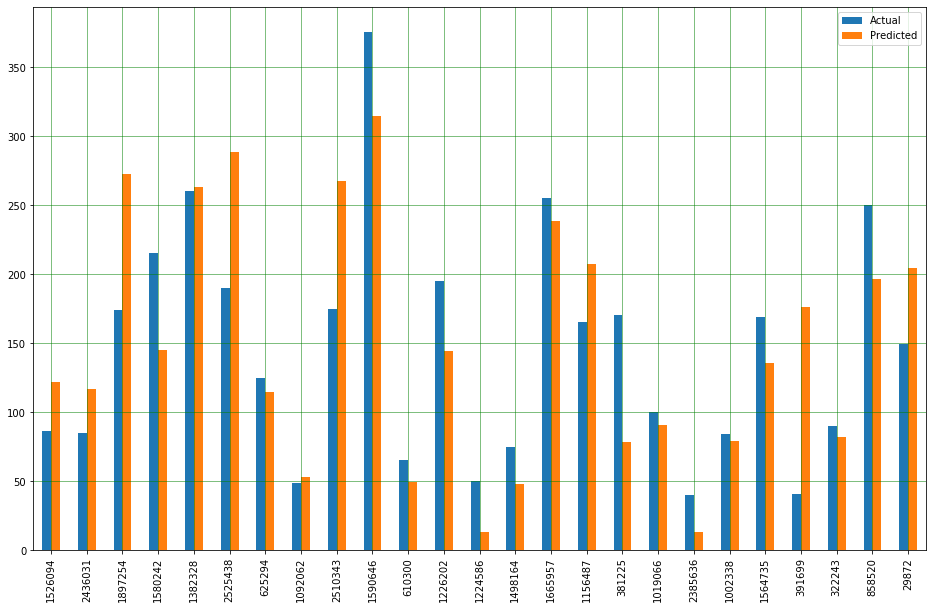

In [28]:
# Plot first 25 actual values and fitted values
y_test_preds = lm_model.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_preds})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [29]:
# List features by coefficients of linear model in ascending order
result.sort_values(by="feature_coeff_abs",ascending=False).head(20)

,feature_names,feature_coeff,feature_coeff_abs
13,host_listings_count,-3.264714e+11,3.264714e+11
15,host_total_listings_count,3.264714e+11,3.264714e+11
85,calendar_updated_16 months ago,1.656935e+02,1.656935e+02
215,neighbourhood_cleansed_South Boston Waterfront,1.396481e+02,1.396481e+02
86,calendar_updated_17 months ago,1.294785e+02,1.294785e+02
98,calendar_updated_30 months ago,1.148795e+02,1.148795e+02
118,cancellation_policy_super_strict_30,1.094394e+02,1.094394e+02
131,neighbourhood_cleansed_Bay Village,9.462600e+01,9.462600e+01
130,neighbourhood_cleansed_Back Bay,8.995590e+01,8.995590e+01
132,neighbourhood_cleansed_Beacon Hill,8.970210e+01,8.970210e+01


In [30]:
# Drop collinear review variables:
reviews_cols = df_new.columns[df_new.columns.str.contains("review") ==True]
reviews_cols= reviews_cols.drop("review_scores_rating")
df_new1 = df_new.drop(reviews_cols,axis=1)

## apply linear model
test_score1, train_score1, lm_model1, X_train1, X_test1, y_train1, y_test1, result1 = linear_mod(df_new1, 'price')


print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score1.round(4), test_score1.round(4)))

The rsquared on the training data was 0.51.  The rsquared on the test data was 0.5102.


In [90]:
# List features by coefficients of linear model in ascending order
result_list = result1.sort_values(by="feature_coeff_abs",ascending=False).head(20)
result_list
#result_list.to_csv("lm_model_results.csv")

,feature_names,feature_coeff,feature_coeff_abs
78,calendar_updated_16 months ago,168.2127,168.2127
208,neighbourhood_cleansed_South Boston Waterfront,136.3390,136.3390
79,calendar_updated_17 months ago,132.2360,132.2360
91,calendar_updated_30 months ago,110.0502,110.0502
111,cancellation_policy_super_strict_30,109.5026,109.5026
86,calendar_updated_23 months ago,95.1756,95.1756
124,neighbourhood_cleansed_Bay Village,93.6829,93.6829
236,property_type_Dorm,-89.3708,89.3708
123,neighbourhood_cleansed_Back Bay,87.6299,87.6299
125,neighbourhood_cleansed_Beacon Hill,86.8803,86.8803


**Summary Linear Model: Which Features are highly Related to “Price”?**

The R-square score on the train data is 0.5121 and on the train data is 0.5122. R-square score on the train data without collinear review variables is 0.51 and on the train data is 0.5102. When we compare both R-square scores, the review variables only have a small effect on our linear model. The coefficient table shows a list of 20 features of higher correlations to price. These are mostly neighborhood areas with higher rates, for example Waterfront and Bay Village in Boston. It is also obvious that the higher the rates the less frequent the hosts updated its calendar. 

## Catboost 

**Can we have a better prediction by using other Model?** <br> I decide to use catboost model.
CatBoost is a machine learning algorithm that uses gradient boosting on decision trees.

In [32]:
def catboost_mod(df, response_col, iterations, learning_rate):
    # Now let's separate features and label variable:
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Let's split the train data into training and validation sets.

    X_train_cat, X_validation_cat, y_train_cat, y_validation_cat = train_test_split(X, y, test_size=0.3)

    train_pool = Pool(X_train_cat, y_train_cat)#, cat_features=categorical_features_indices)
    validate_pool = Pool(X_validation_cat, y_validation_cat)#, cat_features=categorical_features_indices)


    cat_model = CatBoostRegressor(iterations=iterations,
                              learning_rate=learning_rate)
    # Fit model
    cat_model.fit(train_pool)

    # Get predictions
    preds = cat_model.predict(validate_pool)

    #Score using your model
    val_score_cat = cat_model.score(validate_pool)
    train_score_cat = cat_model.score(train_pool)
    
    # Mean squared error
    train_error_cat = mean_squared_error(cat_model.predict(X_train_cat), y_train_cat)
    val_error_cat = mean_squared_error(cat_model.predict(X_validation_cat), y_validation_cat)
    
    #Feature importance
    #PredictionValuesChange

    #The individual importance values for each of the input features 
    #(the default feature importances calculation method for non-ranking metrics).

    #For each feature, PredictionValuesChange shows how much on average the prediction changes 
    #if the feature value changes. The bigger the value of the importance the bigger on average 
    #is the change to the prediction value, if this feature is changed.
    feature_importances = cat_model.get_feature_importance(train_pool)
    feature_names = X_train_cat.columns

    feature_colnames = ["feature_importances","feature_names"]
    values = [feature_names,feature_importances]

    importance = list(zip(feature_colnames,values))
    importance = dict(importance)
    result_cat = pd.DataFrame(importance)
    

    return val_score_cat, train_score_cat, val_error_cat, train_error_cat, cat_model, X_train_cat, X_validation_cat, y_train_cat, y_validation_cat, result_cat

# apply catboost model
val_score_cat, train_score_cat, val_error_cat, train_error_cat, cat_model, X_train_cat, X_validation_cat, y_train_cat, y_validation_cat, result_cat = catboost_mod(df_new,"price",1000, 0.1)

0:	learn: 118.9962612	total: 227ms	remaining: 3m 46s
1:	learn: 115.0645302	total: 377ms	remaining: 3m 8s
2:	learn: 111.7655395	total: 515ms	remaining: 2m 51s
3:	learn: 108.8503367	total: 655ms	remaining: 2m 43s
4:	learn: 106.5024463	total: 788ms	remaining: 2m 36s
5:	learn: 104.4502088	total: 919ms	remaining: 2m 32s
6:	learn: 102.5465137	total: 1.05s	remaining: 2m 29s
7:	learn: 100.6759653	total: 1.18s	remaining: 2m 26s
8:	learn: 98.4769228	total: 1.3s	remaining: 2m 23s
9:	learn: 97.0040474	total: 1.43s	remaining: 2m 21s
10:	learn: 93.9355859	total: 1.57s	remaining: 2m 20s
11:	learn: 92.6627912	total: 1.68s	remaining: 2m 18s
12:	learn: 91.4101328	total: 1.81s	remaining: 2m 17s
13:	learn: 89.8039823	total: 1.98s	remaining: 2m 19s
14:	learn: 88.8744184	total: 2.11s	remaining: 2m 18s
15:	learn: 88.0034895	total: 2.26s	remaining: 2m 19s
16:	learn: 87.2300749	total: 2.39s	remaining: 2m 18s
17:	learn: 86.5193887	total: 2.5s	remaining: 2m 16s
18:	learn: 85.9063457	total: 2.63s	remaining: 2m 15

157:	learn: 45.8214344	total: 21s	remaining: 1m 51s
158:	learn: 45.6106420	total: 21.2s	remaining: 1m 51s
159:	learn: 45.5143409	total: 21.3s	remaining: 1m 51s
160:	learn: 45.4552624	total: 21.4s	remaining: 1m 51s
161:	learn: 45.3629290	total: 21.6s	remaining: 1m 51s
162:	learn: 45.2624969	total: 21.8s	remaining: 1m 51s
163:	learn: 45.2013169	total: 21.9s	remaining: 1m 51s
164:	learn: 45.0579014	total: 22s	remaining: 1m 51s
165:	learn: 44.9666590	total: 22.2s	remaining: 1m 51s
166:	learn: 44.8902145	total: 22.3s	remaining: 1m 51s
167:	learn: 44.7864926	total: 22.5s	remaining: 1m 51s
168:	learn: 44.7386765	total: 22.6s	remaining: 1m 51s
169:	learn: 44.6468218	total: 22.8s	remaining: 1m 51s
170:	learn: 44.5686107	total: 22.9s	remaining: 1m 50s
171:	learn: 44.4776754	total: 23s	remaining: 1m 50s
172:	learn: 44.1213431	total: 23.1s	remaining: 1m 50s
173:	learn: 44.0157963	total: 23.3s	remaining: 1m 50s
174:	learn: 43.9480147	total: 23.4s	remaining: 1m 50s
175:	learn: 43.8658623	total: 23.5

311:	learn: 34.9493918	total: 40.5s	remaining: 1m 29s
312:	learn: 34.9214668	total: 40.7s	remaining: 1m 29s
313:	learn: 34.8667682	total: 40.8s	remaining: 1m 29s
314:	learn: 34.8001156	total: 40.9s	remaining: 1m 28s
315:	learn: 34.7334205	total: 41s	remaining: 1m 28s
316:	learn: 34.6880768	total: 41.2s	remaining: 1m 28s
317:	learn: 34.6467540	total: 41.3s	remaining: 1m 28s
318:	learn: 34.5993481	total: 41.5s	remaining: 1m 28s
319:	learn: 34.5503672	total: 41.6s	remaining: 1m 28s
320:	learn: 34.4958346	total: 41.7s	remaining: 1m 28s
321:	learn: 34.4721365	total: 41.9s	remaining: 1m 28s
322:	learn: 34.4436019	total: 42s	remaining: 1m 28s
323:	learn: 34.4011923	total: 42.2s	remaining: 1m 27s
324:	learn: 34.3416088	total: 42.3s	remaining: 1m 27s
325:	learn: 34.3113511	total: 42.4s	remaining: 1m 27s
326:	learn: 34.2665440	total: 42.6s	remaining: 1m 27s
327:	learn: 34.1230194	total: 42.7s	remaining: 1m 27s
328:	learn: 34.0796994	total: 42.8s	remaining: 1m 27s
329:	learn: 34.0452944	total: 42

465:	learn: 28.9510230	total: 1m	remaining: 1m 9s
466:	learn: 28.9315435	total: 1m	remaining: 1m 9s
467:	learn: 28.8903858	total: 1m	remaining: 1m 9s
468:	learn: 28.8143434	total: 1m 1s	remaining: 1m 9s
469:	learn: 28.7834032	total: 1m 1s	remaining: 1m 8s
470:	learn: 28.7455064	total: 1m 1s	remaining: 1m 8s
471:	learn: 28.7106921	total: 1m 1s	remaining: 1m 8s
472:	learn: 28.6774881	total: 1m 1s	remaining: 1m 8s
473:	learn: 28.6214817	total: 1m 1s	remaining: 1m 8s
474:	learn: 28.5974977	total: 1m 1s	remaining: 1m 8s
475:	learn: 28.5631511	total: 1m 1s	remaining: 1m 8s
476:	learn: 28.5501097	total: 1m 2s	remaining: 1m 7s
477:	learn: 28.5175444	total: 1m 2s	remaining: 1m 7s
478:	learn: 28.4915659	total: 1m 2s	remaining: 1m 7s
479:	learn: 28.4424019	total: 1m 2s	remaining: 1m 7s
480:	learn: 28.4094321	total: 1m 2s	remaining: 1m 7s
481:	learn: 28.3846641	total: 1m 2s	remaining: 1m 7s
482:	learn: 28.3480763	total: 1m 2s	remaining: 1m 7s
483:	learn: 28.3174887	total: 1m 2s	remaining: 1m 7s
48

619:	learn: 24.7597824	total: 1m 21s	remaining: 49.9s
620:	learn: 24.7352760	total: 1m 21s	remaining: 49.7s
621:	learn: 24.7190353	total: 1m 21s	remaining: 49.6s
622:	learn: 24.6900562	total: 1m 21s	remaining: 49.5s
623:	learn: 24.6606435	total: 1m 21s	remaining: 49.3s
624:	learn: 24.6314245	total: 1m 22s	remaining: 49.2s
625:	learn: 24.6052125	total: 1m 22s	remaining: 49.1s
626:	learn: 24.5756366	total: 1m 22s	remaining: 48.9s
627:	learn: 24.5500245	total: 1m 22s	remaining: 48.8s
628:	learn: 24.5346750	total: 1m 22s	remaining: 48.7s
629:	learn: 24.5204349	total: 1m 22s	remaining: 48.5s
630:	learn: 24.4830124	total: 1m 22s	remaining: 48.4s
631:	learn: 24.4643829	total: 1m 22s	remaining: 48.3s
632:	learn: 24.4390678	total: 1m 23s	remaining: 48.2s
633:	learn: 24.4098577	total: 1m 23s	remaining: 48s
634:	learn: 24.3869348	total: 1m 23s	remaining: 47.9s
635:	learn: 24.3643671	total: 1m 23s	remaining: 47.8s
636:	learn: 24.3415543	total: 1m 23s	remaining: 47.6s
637:	learn: 24.3112327	total: 

773:	learn: 21.5361889	total: 1m 40s	remaining: 29.3s
774:	learn: 21.5127335	total: 1m 40s	remaining: 29.2s
775:	learn: 21.4992641	total: 1m 40s	remaining: 29.1s
776:	learn: 21.4910428	total: 1m 40s	remaining: 29s
777:	learn: 21.4761190	total: 1m 41s	remaining: 28.8s
778:	learn: 21.4609791	total: 1m 41s	remaining: 28.7s
779:	learn: 21.4430096	total: 1m 41s	remaining: 28.6s
780:	learn: 21.4253169	total: 1m 41s	remaining: 28.4s
781:	learn: 21.4067465	total: 1m 41s	remaining: 28.3s
782:	learn: 21.3918230	total: 1m 41s	remaining: 28.2s
783:	learn: 21.3714540	total: 1m 41s	remaining: 28s
784:	learn: 21.3513736	total: 1m 41s	remaining: 27.9s
785:	learn: 21.3380341	total: 1m 42s	remaining: 27.8s
786:	learn: 21.3135860	total: 1m 42s	remaining: 27.6s
787:	learn: 21.2983260	total: 1m 42s	remaining: 27.5s
788:	learn: 21.2815280	total: 1m 42s	remaining: 27.4s
789:	learn: 21.2676349	total: 1m 42s	remaining: 27.3s
790:	learn: 21.2315234	total: 1m 42s	remaining: 27.1s
791:	learn: 21.2090194	total: 1m

927:	learn: 18.9361104	total: 2m	remaining: 9.32s
928:	learn: 18.9254074	total: 2m	remaining: 9.19s
929:	learn: 18.9043040	total: 2m	remaining: 9.06s
930:	learn: 18.8741427	total: 2m	remaining: 8.93s
931:	learn: 18.8636987	total: 2m	remaining: 8.8s
932:	learn: 18.8540002	total: 2m	remaining: 8.67s
933:	learn: 18.8445537	total: 2m	remaining: 8.54s
934:	learn: 18.8320464	total: 2m 1s	remaining: 8.41s
935:	learn: 18.8161438	total: 2m 1s	remaining: 8.29s
936:	learn: 18.7893840	total: 2m 1s	remaining: 8.16s
937:	learn: 18.7736595	total: 2m 1s	remaining: 8.03s
938:	learn: 18.7572145	total: 2m 1s	remaining: 7.89s
939:	learn: 18.7467186	total: 2m 1s	remaining: 7.77s
940:	learn: 18.7326872	total: 2m 1s	remaining: 7.63s
941:	learn: 18.7151586	total: 2m 1s	remaining: 7.51s
942:	learn: 18.7055354	total: 2m 2s	remaining: 7.38s
943:	learn: 18.6896066	total: 2m 2s	remaining: 7.25s
944:	learn: 18.6751571	total: 2m 2s	remaining: 7.12s
945:	learn: 18.6577602	total: 2m 2s	remaining: 6.99s
946:	learn: 18.

In [33]:
print("The rsquared on the training data was {}. The rsquared on the validation data was {}.".format(train_score_cat.round(4), val_score_cat.round(4)))
print("The mean squared error on the training data was {}. The mean squared error on the validation data was {}.".format(train_error_cat.round(4), val_error_cat.round(4)))

The rsquared on the training data was 0.9792. The rsquared on the validation data was 0.9794.
The mean squared error on the training data was 318.5166. The mean squared error on the validation data was 321.3407.


In [92]:
feature_importance = result_cat.sort_values(by="feature_names",ascending=False).head(10)

fig = go.Figure()
fig.add_trace(go.Bar(x = feature_importance.feature_importances, y=feature_importance.feature_names))

**Summary - Answer Question 3** <br>
Catboost is a fast, scalable, high-performance gradient boosting on decision trees library. Used for ranking, classification, regression, and other ML tasks. CatboostRegressor is comparing to LinearRegression a better model choice, because Gradient boosting benefits from training on huge datasets. It also has an algorithm for finding the most influential training samples for a given feature by get_feature_importance() function. This function calculates the effect of features from the training dataset on the optimized metric values for the features from the input dataset.
I tried different learning rates and iterations, the results of most combinations provide a pretty high R-square score above 0.95. 
With a learning rate = 0.7 the R-square score of CatboostRegressor on the training data is 0.9792 and on the test data is 0.9794, mean squared error on test data is 321.3407. It seems to be overfitting, but the result is better than LinearRegression.
The feature importance function shows that "accommodates", "extra_people", "weekly_price", "number of bedrooms" have a bigger impact on the listing price, which is different from the results of Linear Regression.